# TP2: Camera Calibration

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

To execute a notebook, you will need to [install jupyter](http://jupyter.org/install.html). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf.

In [154]:
# See TP1 for information about those imports
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.ndimage as ndimage
plt.rcParams['image.cmap'] = 'gray' 

# Useful for loading mat files
import scipy.io as sio

# Useful for optimization
import scipy.optimize as optimize

Download the [data](http://imagine.enpc.fr/~aubrym/lectures/introvis17/clean_points.mat ). Load the data:

In [207]:
data = sio.loadmat('clean_points.mat')
pts2d = data['pts2d']
pts3d = data['pts3d']

`pts2d` and `pts3d` are two vector of corresponding points in the image and in 3D. We will use these correspondences to calibrate the camera.

### Linear Method

We first try to perform camera calibration using the linear method. From the lecture, we know that it ideally solves an equation ($\mathbf 0$ being a vector, and $\mathbf p$ a vector representation of the camera matrix)

$$A \mathbf p = \mathbf 0$$

**1.** Build the matrix `A` that defines this calibration equation. What are its dimensions?

In [156]:
# 1

def Build_A (points3d,points2d):
    
    n=points3d.shape[0]
    homogenous_points3d=np.c_[points3d,np.ones(n)]
    A=np.zeros((2*n,12))
    
    A[::2,:4]=homogenous_points3d
    A[1::2,4:8]=homogenous_points3d
    A[::2,8:12]=-np.dot(np.diag(points2d[:,0]),homogenous_points3d)
    A[1::2,8:12]=-np.dot(np.diag(points2d[:,1]),homogenous_points3d)
    
    return A


A = Build_A(pts3d,pts2d)
print("Its dimentions are",A.shape)


Its dimentions are (982, 12)


## what is SVD and how it relates to the eigenvalue? Should we finid the eigenvalues of A ou At*A?

**2.a)** Perform SVD (using `np.linalg.svd`) on `A` .<br/>
**b)** Check that the SVD is coherent and that one of the singular value is close to $0$ .<br/>
**c)** Use this SVD to compute the camera matrix `P`.

In [157]:
#2.a
U, S, V = np.linalg.svd(A)
#2.b
print(min(S))


0.04316114614617875


In [177]:
#2.c
sol = V[-1,:]
P = sol.reshape((3,4))
print(P)

[[-4.53359881e-03 -5.65451256e-04  2.02849590e-03 -5.23179344e-01]
 [-1.84278426e-03  4.15975903e-03 -1.68779276e-03 -8.52192928e-01]
 [-3.25683227e-06 -1.13804182e-06 -3.35237791e-06 -1.43209220e-03]]


**3.** Write a function `projection_error(P, pts3d, pts2d)` that computes the measurement error (Mean Squared Error) between the 3D points projected with a matrix `P`, and the 2D points.

In [229]:
def projection_error(P, pts3d, pts2d):
    
    homogenous_pts3d=np.c_[pts3d,np.ones(len(pts3d))]
    P=P.reshape(3,4)
    projection_homogenous = np.dot(P,np.transpose(homogenous_pts3d))
    projection = np.array([projection_homogenous[0,:]/projection_homogenous[-1,:],
                           projection_homogenous[1,:]/projection_homogenous[-1,:]])
    error = (projection.T - pts2d)
    
    # Flatten the error array to 1D to optmize later
    return error.flatten()
    

MSE = np.mean(projection_error(P, pts3d, pts2d)**2)
print(MSE)

    

0.4582634967385366


**4.** Visualize the projected 3D points and the 2D points on the same figure (use `plt.scatter` with different `marker` options).

Calculating the projected 3D points

In [230]:
homogenous_pts3d=np.c_[pts3d,np.ones(len(pts3d))]
projection_homogenous = np.dot(P,np.transpose(homogenous_pts3d))
projection = np.array([projection_homogenous[0,:]/projection_homogenous[-1,:],
                        projection_homogenous[1,:]/projection_homogenous[-1,:]]).T

Plotting the results:

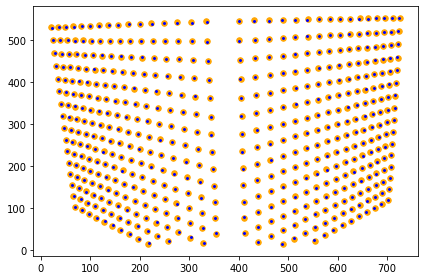

In [161]:
plt.scatter(projection[:,0], projection[:,1], marker='o',c='orange',s=30)
plt.scatter(pts2d[:,0], pts2d[:,1], marker='x',c='blue',s=4)
plt.show()

### Camera parameters

We want to extract the parameters of the camera from the matrix `P`, *i.e.*, the internal $(3\times 3)$ calibration matrix $\mathcal K$, the external $(3\times 3)$ rotation matrix $R$ and the $(3\times 1)$ translation vector $\mathbf t$ so that:

$$P=\mathcal K [R | \mathbf t]$$

To do so, we are going to use the formulas from the lectures, and the numpy functions (`np.linalg.norm`, `np.linalg.inv`, `np.dot`, `np.cross`...).

**5.a)** Write a function `camera_parameters(P, eps=1)` that takes as input the camera matrix `P` and a sign `eps` ($\varepsilon$, the sign of $\rho$ in the equations from the lecture), and outputs three values `K`, `R` and `t` that correspond to the intrinsic and extrinsic parameters of the camera. <br/>
**b)** Display the results for `eps=1` and check that your values `(K, R, t)` can correctly reconstruct `P`.

In [162]:
#5.a)
def camera_parameters(P, eps=1):
    P_square = P[:,:3]
    P_last_column = P[:,-1]

    # Perform RQ decomposition to decompose into K (upper triangular) and R (orthonormal)
    Q, R = np.linalg.qr(np.flipud(P_square).T)  
    R = np.flipud(R.T)  
    R = np.fliplr(R)  
    Q = Q.T
    Q = np.flipud(Q)

    # Back to the notation of the course
    K = R
    R = Q
    
    # solving P_last_column = K*t
    t = np.dot(np.linalg.inv(K),P_last_column)
    rho = K[-1,-1]
    
    # Normalizing K
    K = K/rho
    
    # Correcting the signal of the decomposition to ensure R is a rotation matrix
    K[:,0] = -K[:,0]
    R[0,:] = -R[0,:]
    

    return K, R, t , rho

#5.b)
K, R, t , rho = camera_parameters(P,eps=1)


test = np.dot(rho*K,np.c_[R,t])
print(P)
print(test)


[[-4.53359881e-03 -5.65451256e-04  2.02849590e-03 -5.23179344e-01]
 [-1.84278426e-03  4.15975903e-03 -1.68779276e-03 -8.52192928e-01]
 [-3.25683227e-06 -1.13804182e-06 -3.35237791e-06 -1.43209220e-03]]
[[-4.53359881e-03 -5.65451256e-04  2.02849590e-03 -5.42398211e-01]
 [-1.84278426e-03  4.15975903e-03 -1.68779276e-03 -8.52192928e-01]
 [-3.25683227e-06 -1.13804182e-06 -3.35237791e-06 -1.43209220e-03]]


**6.** The sign of $\rho$ is not easy to decide a priori: test your function with both choices of `eps`, and comment on which option makes more sense (is the object in front of the camera?)

### Non linear method

**7.a)** Improve the estimate of the camera matrix using non linear least squares: use `projection_error` from **3.** and `optimize.leastsq` which implements a variant of Levenberg-Marquardt (read the documentation to use it appropriately). <br/>
**b)** Compare the reprojection error before and after the optimization.

In [231]:
#7.a)
from scipy.optimize import least_squares

Initial_guess = P.flatten()
Result= least_squares(projection_error, Initial_guess, args=(pts3d, pts2d), method='lm').x

New_projection = np.reshape(Result,(3,4))



In [232]:
#7.b)
Before = np.mean(projection_error(P,pts3d,pts2d)**2)
After = np.mean(projection_error(New_projection,pts3d,pts2d)**2)


print("Error before:",Before)
print("Error after:",After)

print(f"The error became {round(After/Before-1,5)*100}% lower")

Error before: 0.4582634967385366
Error after: 0.4571321565929858
The error became -0.247% lower


Points after new projection

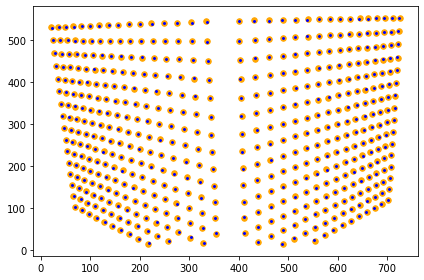

In [233]:
projection_homogenous = np.dot(New_projection,np.transpose(homogenous_pts3d))
projection = np.array([projection_homogenous[0,:]/projection_homogenous[-1,:],
                        projection_homogenous[1,:]/projection_homogenous[-1,:]]).T

plt.scatter(projection[:,0], projection[:,1], marker='o',c='orange',s=30)
plt.scatter(pts2d[:,0], pts2d[:,1], marker='x',c='blue',s=4)
plt.show()